In [16]:
import json

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker

import numpy as np

import openturns as ot
import openturns.viewer as viewer
import openturns.viewer as otv

plt.rcParams['figure.dpi']= 500

KeyError: 'Tex is not a valid rc parameter (see rcParams.keys() for a list of valid parameters)'

# Importing Data

In [2]:
# Color scheme for chemical conditioning
colors_ch = {'Morpholine': {'9.2': ['g', 0.05], '9.6': ['g', 0.2]},
             'ETA': {'9.2': ['b', 0.05], '9.6': ['b', 0.2]},
             'Ammoniaque' : {'9.2': ['r', 0.05], '9.7': ['r', 0.2]}}

In [3]:
labels = [
    r"$\alpha$",
    r"$\beta$",
    r"$\epsilon_e$",
    r"$\epsilon_c$",
    r"$d_p$",
    r"$\Gamma_{p}(0)$",
    r"$a_v$"
]

In [4]:
# Parameters of the Steam Generator
input_dic = {}
input_dic['SG'] = json.load(open('../data/SG_cleaning_conditioning.json'))

In [5]:
# Input-Output of THYC-Puffer-DEPOTHYC in Ho
# Hot leg and Cold leg
dataset_HL = ot.Sample.ImportFromCSVFile('../data/SG_MC_HL.csv')
dataset_CL = ot.Sample.ImportFromCSVFile('../data/SG_MC_CL.csv')

In [6]:
# Monte-Carlo sample of input variables for THYC-Puffer-DEPOTHYC
inputSample = dataset_HL[:,0:7]

In [7]:
# Clogging output as a function of time
outputSample_HL = dataset_HL[:,7:]
outputSample_CL = dataset_CL[:,7:]

In [8]:
# Time indices in days
t = np.load('../data/SG_time.npy')

## General $R^2_{HSIC}$

In [9]:
hsic_time_HL, hsic_time_CL = [], []
estimatorType_u = ot.HSICVStat() 
p_values_HL, p_values_CL = [], []

In [10]:
for i in range(75):
    
    tauSample_HL = outputSample_HL[:,i]
    tauSample_CL = outputSample_CL[:,i]

    covarianceModelCollection_HL, covarianceModelCollection_CL = [], []
    for i in range(7):
        Xi = inputSample.getMarginal(i)
        Cov = ot.SquaredExponential(1)
        Cov.setScale(Xi.computeStandardDeviation())
        covarianceModelCollection_HL.append(Cov)
        covarianceModelCollection_CL.append(Cov)

    covarianceModelCollection_HL.append(ot.SquaredExponential(tauSample_HL.computeStandardDeviation()))
    covarianceModelCollection_CL.append(ot.SquaredExponential(tauSample_CL.computeStandardDeviation()))

    hsic_u_HL = ot.HSICEstimatorGlobalSensitivity(covarianceModelCollection_HL, inputSample, tauSample_HL, estimatorType_u)
    hsic_u_CL = ot.HSICEstimatorGlobalSensitivity(covarianceModelCollection_CL, inputSample, tauSample_CL, estimatorType_u)
    
    r2_u_HL = hsic_u_HL.getR2HSICIndices()
    r2_u_CL = hsic_u_CL.getR2HSICIndices()

    hsic_time_HL.append(list(np.abs(r2_u_HL)))
    hsic_time_CL.append(list(np.abs(r2_u_CL)))
    
    _p_HL, _p_CL = [],[]
    
    for j in range(7):
        _p_HL.append(round(estimatorType_u.computePValue(ot.Gamma(), 969, hsic_u_HL.getHSICIndices()[j], 0.0),4))
        _p_CL.append(round(estimatorType_u.computePValue(ot.Gamma(), 969, hsic_u_CL.getHSICIndices()[j], 0.0),4))

    p_values_HL.append(_p_HL)
    p_values_CL.append(_p_CL)


In [11]:
hsic_time_HL = list(np.transpose(np.asarray(hsic_time_HL)))
hsic_time_CL = list(np.transpose(np.asarray(hsic_time_CL)))

p_values_HL = list(np.transpose(np.asarray(p_values_HL)))
p_values_CL = list(np.transpose(np.asarray(p_values_CL)))

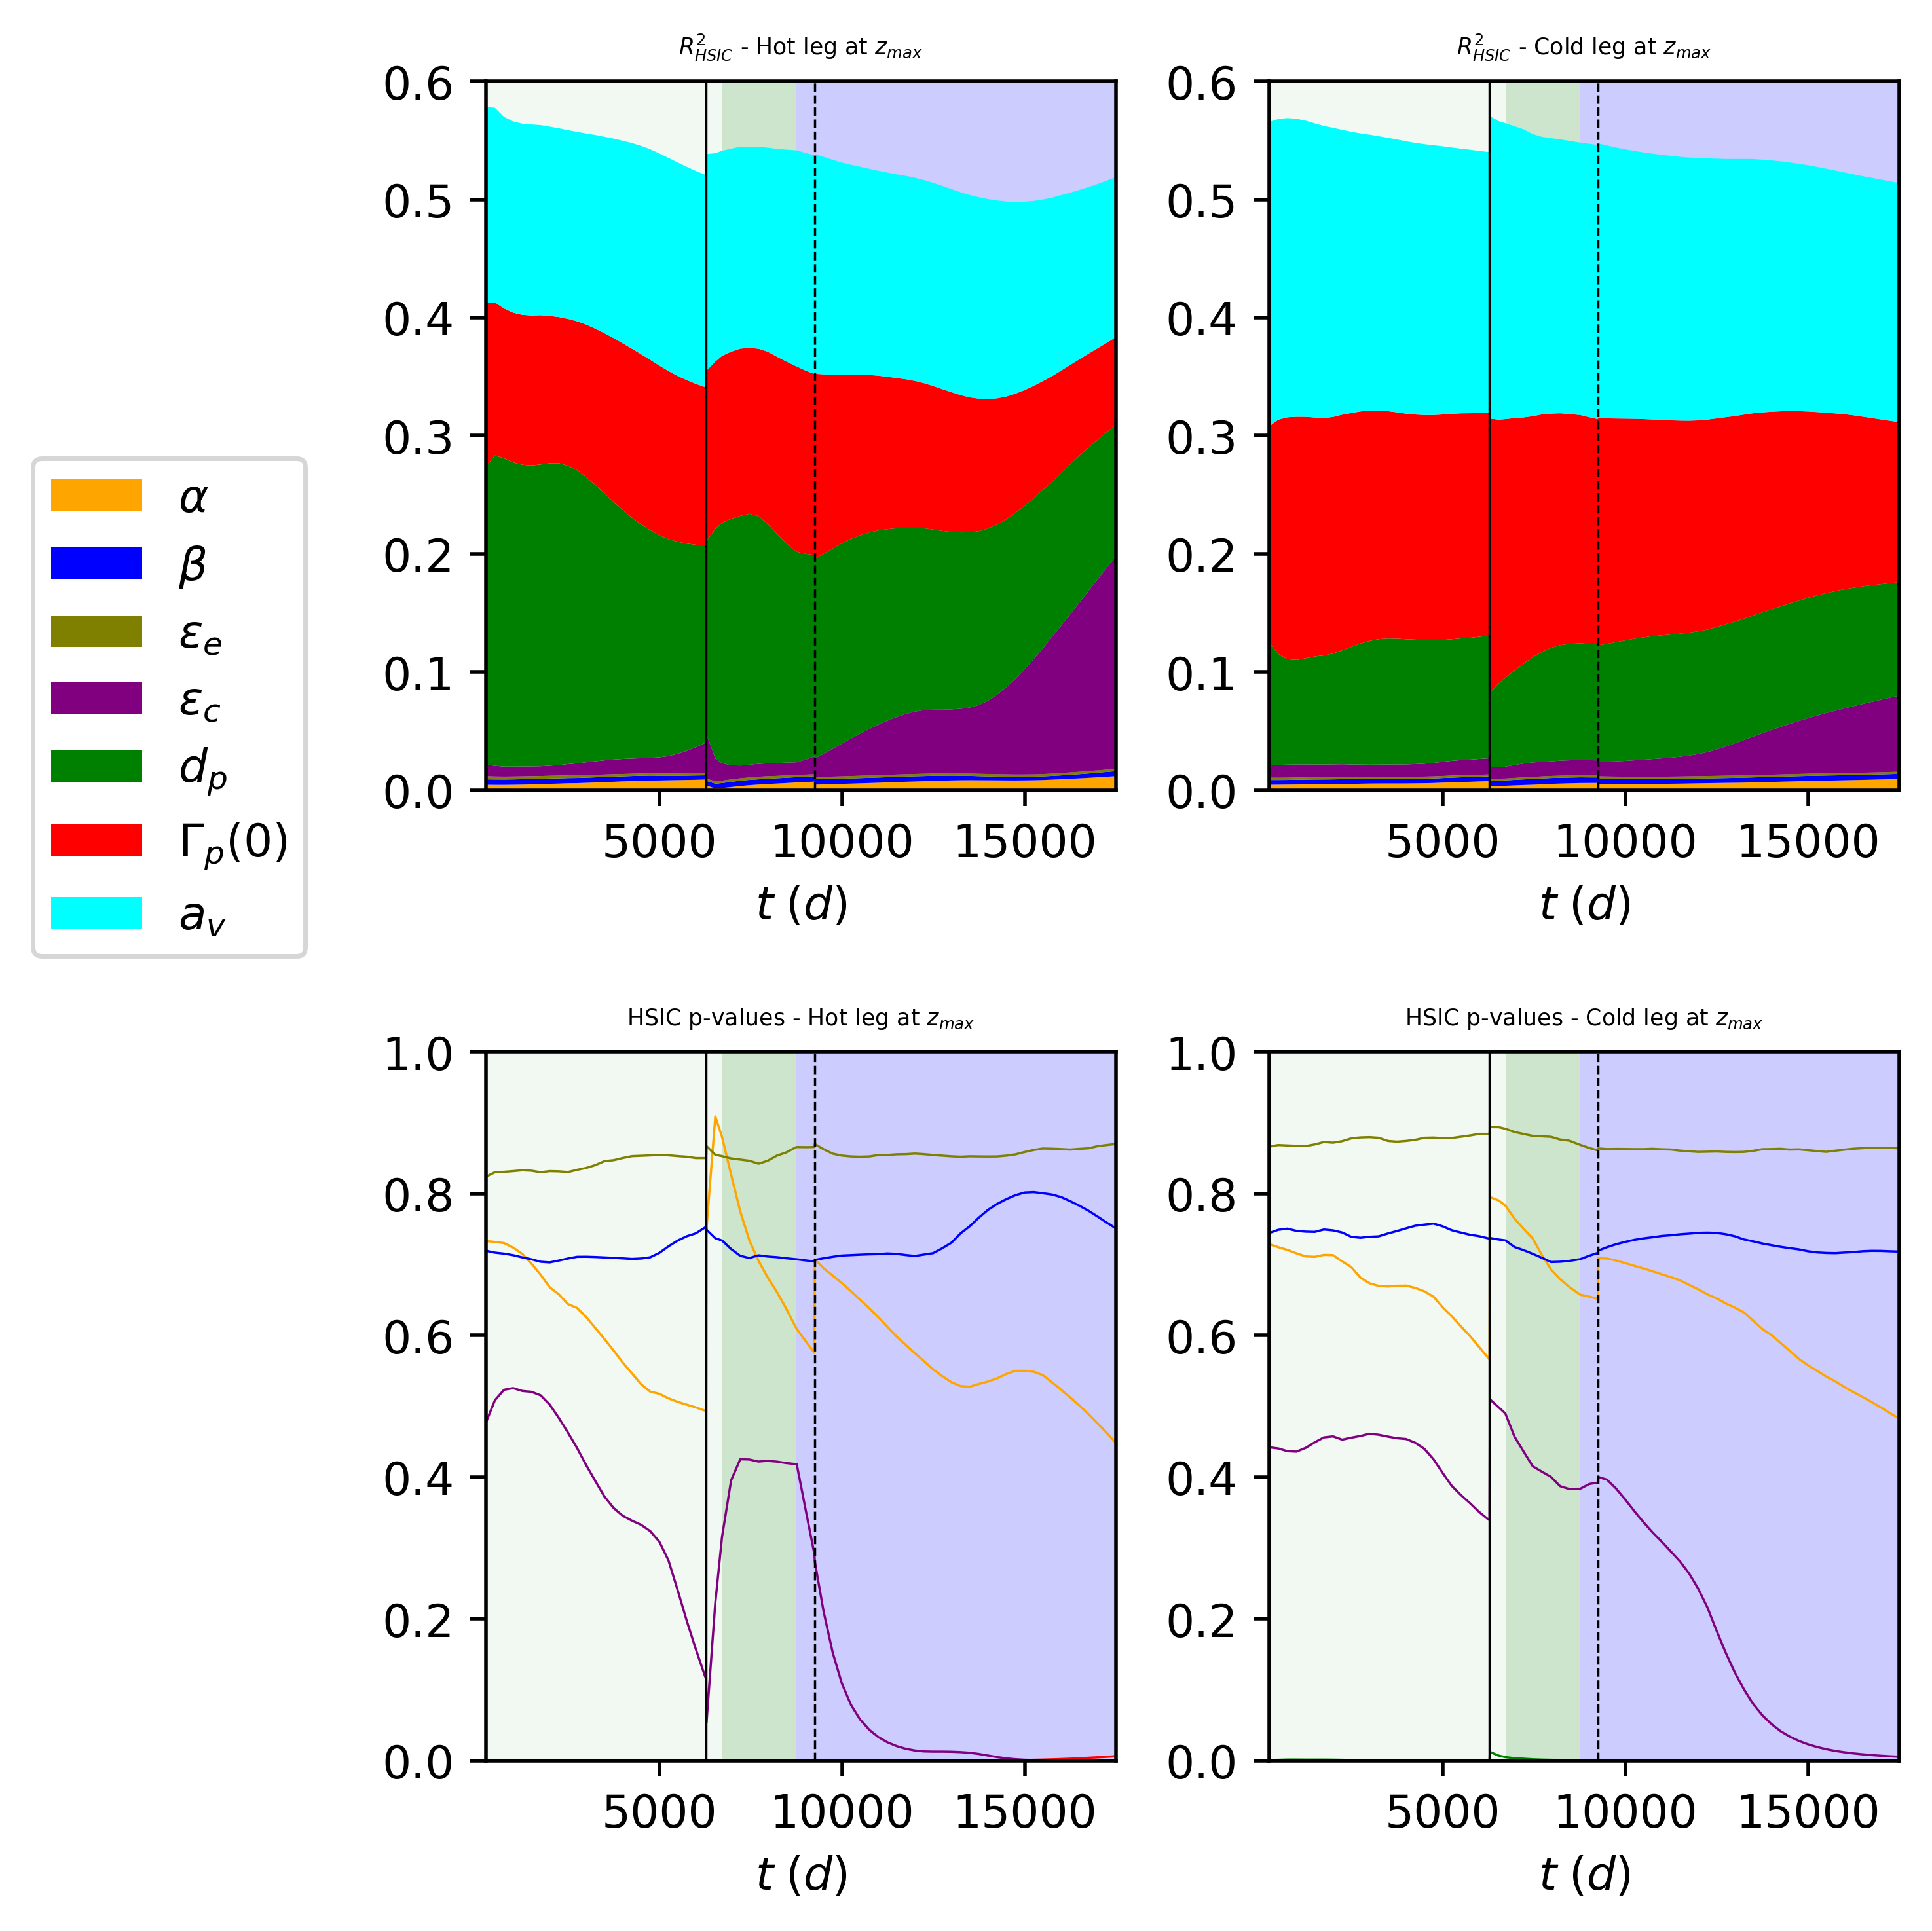

In [13]:
fig, axs = plt.subplots(2,2,figsize=(6,6),layout='tight')
colors = ['orange', 'blue', 'olive','purple', 'green', 'red','cyan']

cond = input_dic['SG']['chimie']['conditionnementSecondaire']
for k in range(len(cond)):
    if k == len(cond)-1:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, max(t)
    else:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, cond[k+1]['nbHeuresExploit']/24
    c = cond[k]
    typ = colors_ch[c['type']]
    col = typ[str(c['ph'])]
    axs[0,0].axvspan(t_i, t_f, facecolor=col[0], alpha = col[1])
    axs[0,1].axvspan(t_i, t_f, facecolor=col[0], alpha = col[1])
    axs[1,0].axvspan(t_i, t_f, facecolor=col[0], alpha = col[1])
    axs[1,1].axvspan(t_i, t_f, facecolor=col[0], alpha = col[1])

axs[0,0].stackplot(t,hsic_time_HL, labels=labels, colors=colors)
axs[0,0].set_xlim(250,17500)
axs[0,0].set_ylim(0,0.6)
axs[0,0].set_xlabel(r'$t\;(d)$')
axs[0,0].set_title(r'$R^{2}_{HSIC}$ - Hot leg at $z_{max}$', fontsize=5)

axs[0,1].stackplot(t,hsic_time_CL, labels=labels, colors=colors)
axs[0,1].set_xlim(250,17500)
axs[0,1].set_ylim(0,0.6)
axs[0,1].set_xlabel(r'$t\;(d)$')
axs[0,1].set_title(r'$R^{2}_{HSIC}$ - Cold leg at $z_{max}$',  fontsize=5)

for k in range(7):
    axs[1,0].plot(t,p_values_HL[k], c=colors[k], linewidth=0.5)
    axs[1,0].set_xlim(250,17500)
    axs[1,0].set_ylim(0,1.0)
    axs[1,0].set_xlabel(r'$t\;(d)$')
    axs[1,0].set_title(r'HSIC p-values - Hot leg at $z_{max}$',  fontsize=5)

    axs[1,1].plot(t,p_values_CL[k], c=colors[k], linewidth=0.5)
    axs[1,1].set_xlim(250,17500)
    axs[1,1].set_ylim(0,1.0)
    axs[1,1].set_xlabel(r'$t\;(d)$')
    axs[1,1].set_title(r'HSIC p-values - Cold leg at $z_{max}$',  fontsize=5)

axs[0,0].legend(bbox_to_anchor=(-0.25,0.5))


nett = input_dic['SG']['chimie']['nettoyage']
for k in range(len(nett)):
    if nett[k]['type'] == 'curatif':
        axs[0,0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        axs[0,1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        axs[1,0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        axs[1,1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        
    elif nett[k]['type'] == 'preventif':
        axs[0,0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)
        axs[0,1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)
        axs[1,0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)
        axs[1,1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)

fig.savefig('../plots/HSIC/R2_HSIC_tot.pdf', format='pdf')
fig.savefig('../plots/HSIC/R2_HSIC_tot.png', format='png')

# Target HSIC for different target levels

In [80]:
tau_levels = [10*i for i in range(10)]

In [81]:
hsic_target_diff_time_HL, hsic_target_diff_time_CL = [], []
p_values_target_diff_HL, p_values_target_diff_CL = [], []
estimatorType_v = ot.HSICVStat() 

In [82]:
for tau in tau_levels:
    #Target levels
    dist = ot.DistanceToDomainFunction(ot.Interval(tau, float('inf')))
    func = ot.SymbolicFunction('x', 'exp(-0.5 * x)')
    weight = ot.ComposedFunction(func, dist)

    hsic_target_HL, hsic_target_CL = [], []
    p_values_target_HL, p_values_target_CL = [], []

    for i in range(75):

        tauSample_HL = outputSample_HL[:,i]
        tauSample_CL = outputSample_CL[:,i]
            
        covarianceModelCollection_HL, covarianceModelCollection_CL = [], []
        
        for j in range(7):
            Xi = inputSample.getMarginal(j)
            Cov = ot.SquaredExponential(1)
            Cov.setScale(Xi.computeStandardDeviation())
            covarianceModelCollection_HL.append(Cov)
            covarianceModelCollection_CL.append(Cov)

        covarianceModelCollection_HL.append(ot.SquaredExponential(tauSample_HL.computeStandardDeviation()))
        covarianceModelCollection_CL.append(ot.SquaredExponential(tauSample_CL.computeStandardDeviation()))

        hsic_v_target_HL = ot.HSICEstimatorTargetSensitivity(covarianceModelCollection_HL, inputSample, tauSample_HL, estimatorType_v, weight)
        hsic_v_target_CL = ot.HSICEstimatorTargetSensitivity(covarianceModelCollection_CL, inputSample, tauSample_CL, estimatorType_v, weight)
        
        r2_v_target_HL = hsic_v_target_HL.getR2HSICIndices()
        r2_v_target_CL = hsic_v_target_CL.getR2HSICIndices()

        hsic_target_HL.append(list(np.abs(r2_v_target_HL)))
        hsic_target_CL.append(list(np.abs(r2_v_target_CL)))

        small_p_HL, small_p_CL = [], []

        for j in range(7):
            small_p_HL.append(round(estimatorType_v.computePValue(ot.Gamma(), 969, hsic_v_target_HL.getR2HSICIndices()[j], 0.0),4))
            small_p_CL.append(round(estimatorType_v.computePValue(ot.Gamma(), 969, hsic_v_target_CL.getR2HSICIndices()[j], 0.0),4))

        p_values_target_HL.append(small_p_HL)
        p_values_target_CL.append(small_p_CL)
    
    hsic_target_diff_time_HL.append(hsic_target_HL)
    hsic_target_diff_time_CL.append(hsic_target_CL)
    p_values_target_diff_HL.append(p_values_target_HL)
    p_values_target_diff_CL.append(p_values_target_CL)
    

## For the Hot Leg - HL

In [83]:
hsic_target_diff_time_HL = np.asarray(hsic_target_diff_time_HL)

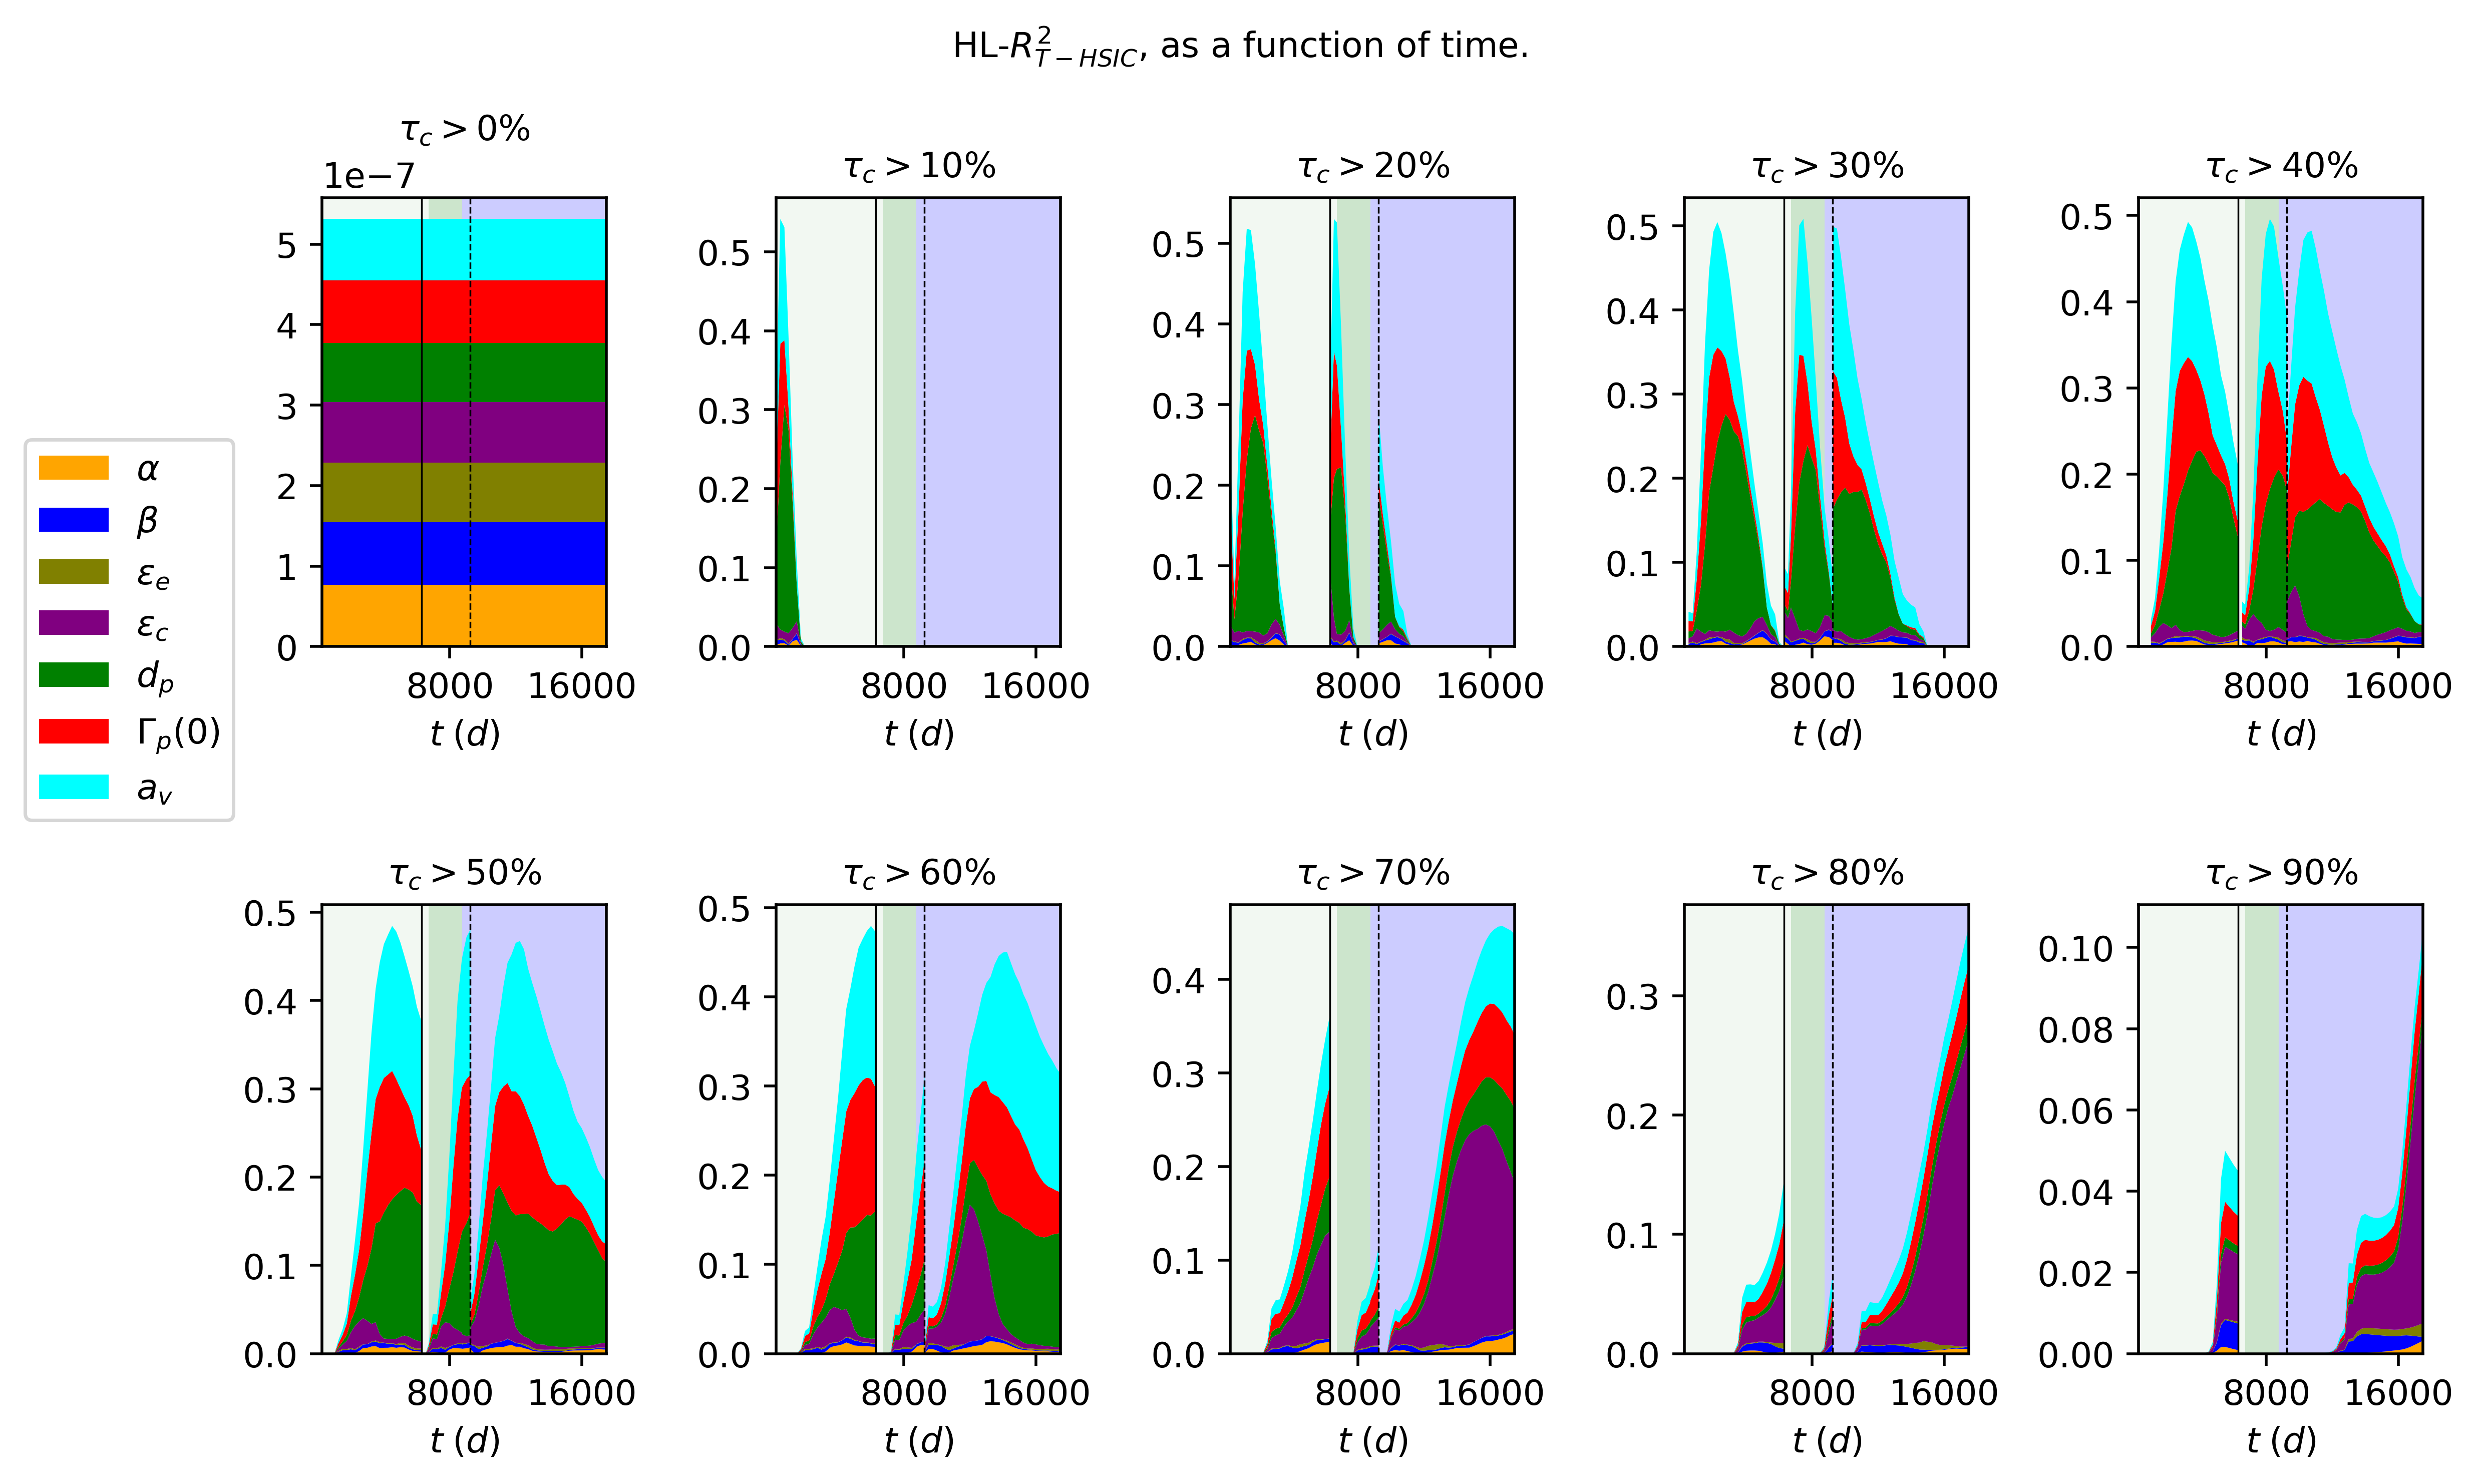

In [87]:
#Plot for different 

nrow, ncol = 2, 5
fig, axs = plt.subplots(nrow, ncol, figsize=(10,6), layout='tight')

colors = ['orange', 'blue', 'olive','purple', 'green', 'red','cyan']

cond = input_dic['SG']['chimie']['conditionnementSecondaire']
for k in range(len(cond)):
    if k == len(cond)-1:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, max(t)
    else:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, cond[k+1]['nbHeuresExploit']/24
    c = cond[k]
    typ = colors_ch[c['type']]
    col = typ[str(c['ph'])]
    for i, ax in enumerate(fig.axes):
            ax.axvspan(t_i, t_f, facecolor=col[0], alpha = col[1])
for i, ax in enumerate(fig.axes):
    ax.stackplot(t,hsic_target_diff_time_HL[i].T, labels=labels, colors=colors)
    ax.set_xlim(250,17500)
    ax.xaxis.set_major_locator(plt.MaxNLocator(1))
    ax.set_xlabel(r'$t\;(d)$')
    ax.set_title(r'$\tau_c > {}\%$'.format(tau_levels[i]), fontsize=10)

nett = input_dic['SG']['chimie']['nettoyage']
for k in range(len(nett)):
    if nett[k]['type'] == 'curatif':
        for i, ax in enumerate(fig.axes):
            ax.axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)

    elif nett[k]['type'] == 'preventif':
        for i, ax in enumerate(fig.axes):
            ax.axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)

axs[0,0].legend(bbox_to_anchor=(-0.25,0.5))
fig.suptitle(r'HL-$R^2_{T-HSIC}$, as a function of time.', fontsize=10)

fig.savefig('../plots/HSIC/HL_target_HSIC.pdf', format='pdf')
fig.savefig('../plots/HSIC/HL_target_HSIC.png', format='png')

        

## HL - p-values

In [88]:
p_values_target_diff_HL = np.asarray(p_values_target_diff_HL)

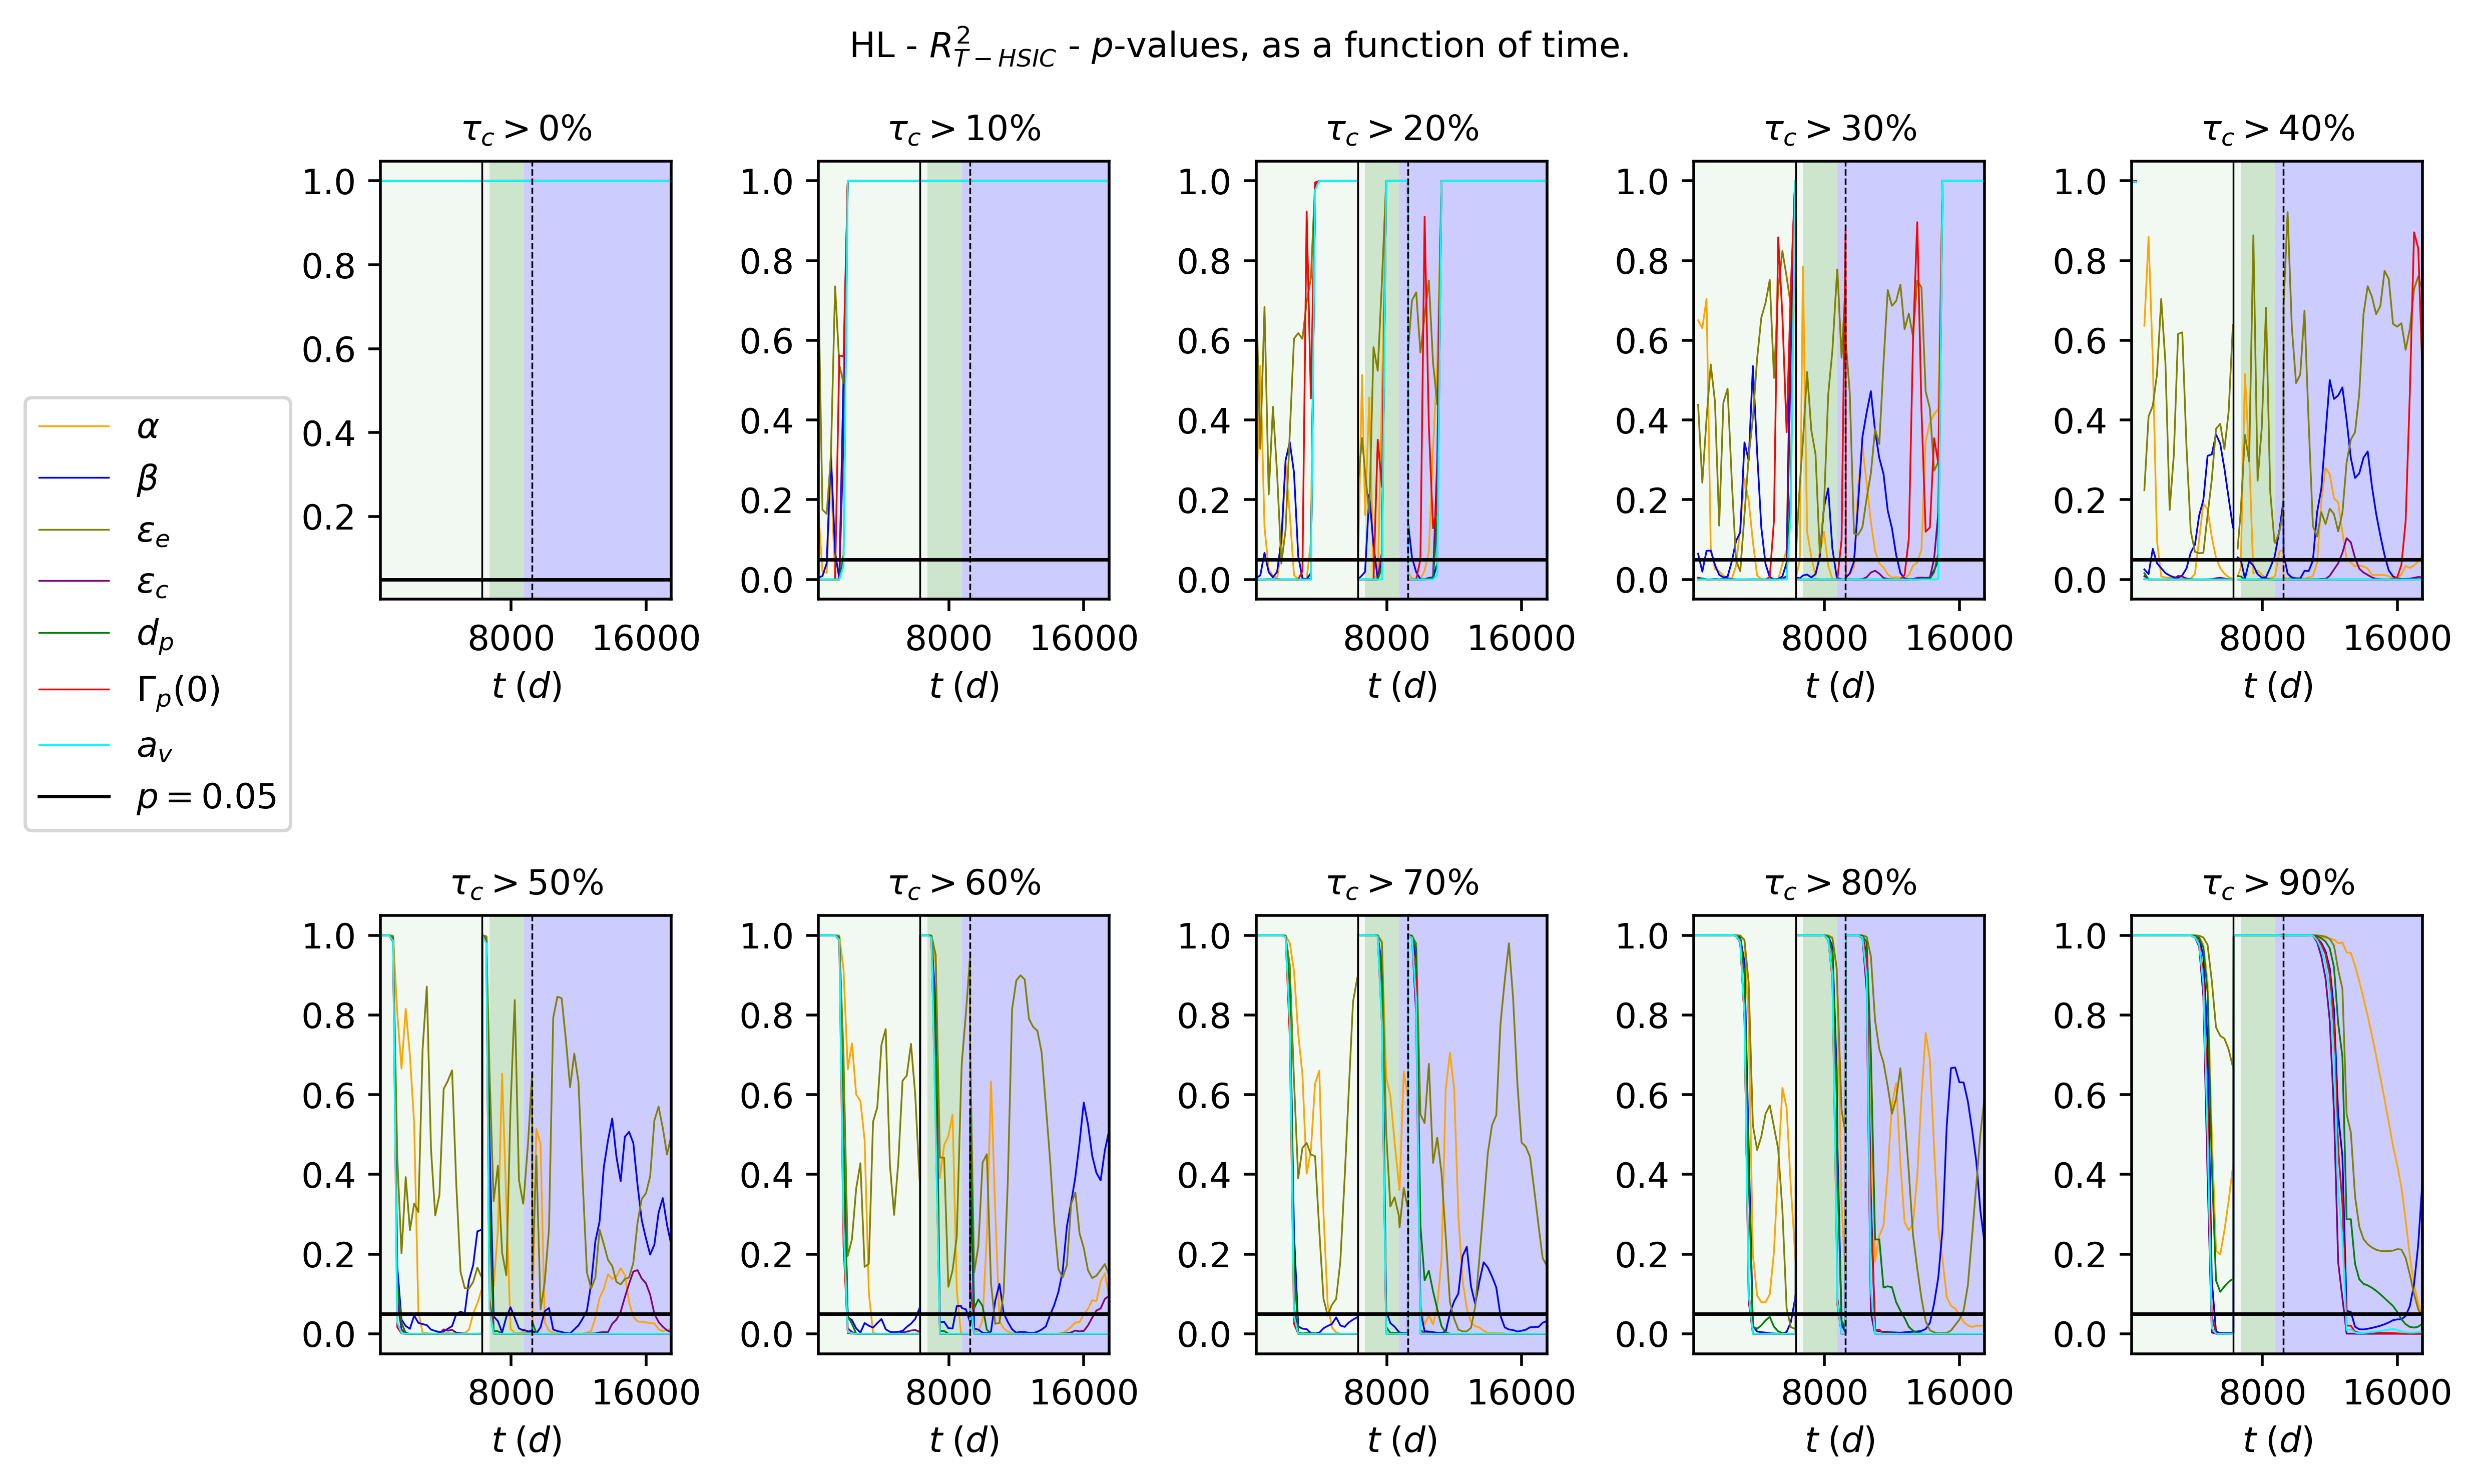

In [108]:
#Plot for different 
nrow, ncol = 2, 5
fig, axs = plt.subplots(nrow, ncol, figsize=(10,6), layout='tight')

colors = ['orange', 'blue', 'olive','purple', 'green', 'red','cyan']

cond = input_dic['SG']['chimie']['conditionnementSecondaire']
for k in range(len(cond)):
    if k == len(cond)-1:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, max(t)
    else:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, cond[k+1]['nbHeuresExploit']/24
    c = cond[k]
    typ = colors_ch[c['type']]
    col = typ[str(c['ph'])]
    for i, ax in enumerate(fig.axes):
            ax.axvspan(t_i, t_f, facecolor=col[0], alpha = col[1])
for i, ax in enumerate(fig.axes):
    for k in range(7):
        ax.plot(t,p_values_target_diff_HL[i].T[k], label=labels[k], c=colors[k], linewidth=0.5)
    ax.set_xlim(250,17500)
    ax.xaxis.set_major_locator(plt.MaxNLocator(1))
    ax.set_xlabel(r'$t\;(d)$')
    ax.axhline(y=0.05, linewidth=1.0, color='k', label=r'$p=0.05$')
    ax.set_title(r'$\tau_c > {}\%$'.format(tau_levels[i]), fontsize=10)

nett = input_dic['SG']['chimie']['nettoyage']
for k in range(len(nett)):
    if nett[k]['type'] == 'curatif':
        for i, ax in enumerate(fig.axes):
            ax.axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)

    elif nett[k]['type'] == 'preventif':
        for i, ax in enumerate(fig.axes):
            ax.axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)

axs[0,0].legend(bbox_to_anchor=(-0.25,0.5))
fig.suptitle(r'HL - $R^2_{T-HSIC}$ - $p$-values, as a function of time.', fontsize=10)

fig.savefig('../plots/HSIC/HL_target_HSIC_pval.pdf', format='pdf')
fig.savefig('../plots/HSIC/HL_target_HSIC_pval.png', format='png')
        

# Conditional HSIC for different clogging levels

In [101]:
hsic_cond_diff_time_HL, hsic_cond_diff_time_CL = [], []
p_values_cond_diff_HL, p_values_cond_diff_CL = [], []
estimatorType_v = ot.HSICVStat() 

In [102]:
for tau in tau_levels:
    #Target levels
    dist = ot.DistanceToDomainFunction(ot.Interval(tau, float('inf')))
    func = ot.SymbolicFunction('x', 'exp(-0.5 * x)')
    weight = ot.ComposedFunction(func, dist)

    hsic_cond_HL, hsic_cond_CL = [], []
    p_values_cond_HL, p_values_cond_CL = [], []

    for i in range(75):

        tauSample_HL = outputSample_HL[:,i]
        tauSample_CL = outputSample_CL[:,i]
            
        covarianceModelCollection_HL, covarianceModelCollection_CL = [], []
        
        for j in range(7):
            Xi = inputSample.getMarginal(j)
            Cov = ot.SquaredExponential(1)
            Cov.setScale(Xi.computeStandardDeviation())
            covarianceModelCollection_HL.append(Cov)
            covarianceModelCollection_CL.append(Cov)

        covarianceModelCollection_HL.append(ot.SquaredExponential(tauSample_HL.computeStandardDeviation()))
        covarianceModelCollection_CL.append(ot.SquaredExponential(tauSample_CL.computeStandardDeviation()))

        hsic_v_cond_HL = ot.HSICEstimatorConditionalSensitivity(covarianceModelCollection_HL, inputSample, tauSample_HL, weight)
        hsic_v_cond_CL = ot.HSICEstimatorConditionalSensitivity(covarianceModelCollection_CL, inputSample, tauSample_CL, weight)
        
        r2_v_cond_HL = hsic_v_cond_HL.getR2HSICIndices()
        r2_v_cond_CL = hsic_v_cond_CL.getR2HSICIndices()

        hsic_cond_HL.append(list(np.abs(r2_v_cond_HL)))
        hsic_cond_CL.append(list(np.abs(r2_v_cond_CL)))

        small_p_HL, small_p_CL = [], []

        for j in range(7):
            small_p_HL.append(round(estimatorType_v.computePValue(ot.Gamma(), 969, hsic_v_cond_HL.getR2HSICIndices()[j], 0.0),4))
            small_p_CL.append(round(estimatorType_v.computePValue(ot.Gamma(), 969, hsic_v_cond_CL.getR2HSICIndices()[j], 0.0),4))

        p_values_cond_HL.append(small_p_HL)
        p_values_cond_CL.append(small_p_CL)
    
    hsic_cond_diff_time_HL.append(hsic_cond_HL)
    hsic_cond_diff_time_CL.append(hsic_cond_CL)
    p_values_cond_diff_HL.append(p_values_cond_HL)
    p_values_cond_diff_CL.append(p_values_cond_CL)
    

## For the Hot Leg - HL

In [109]:
hsic_cond_diff_time_HL = np.asarray(hsic_cond_diff_time_HL)

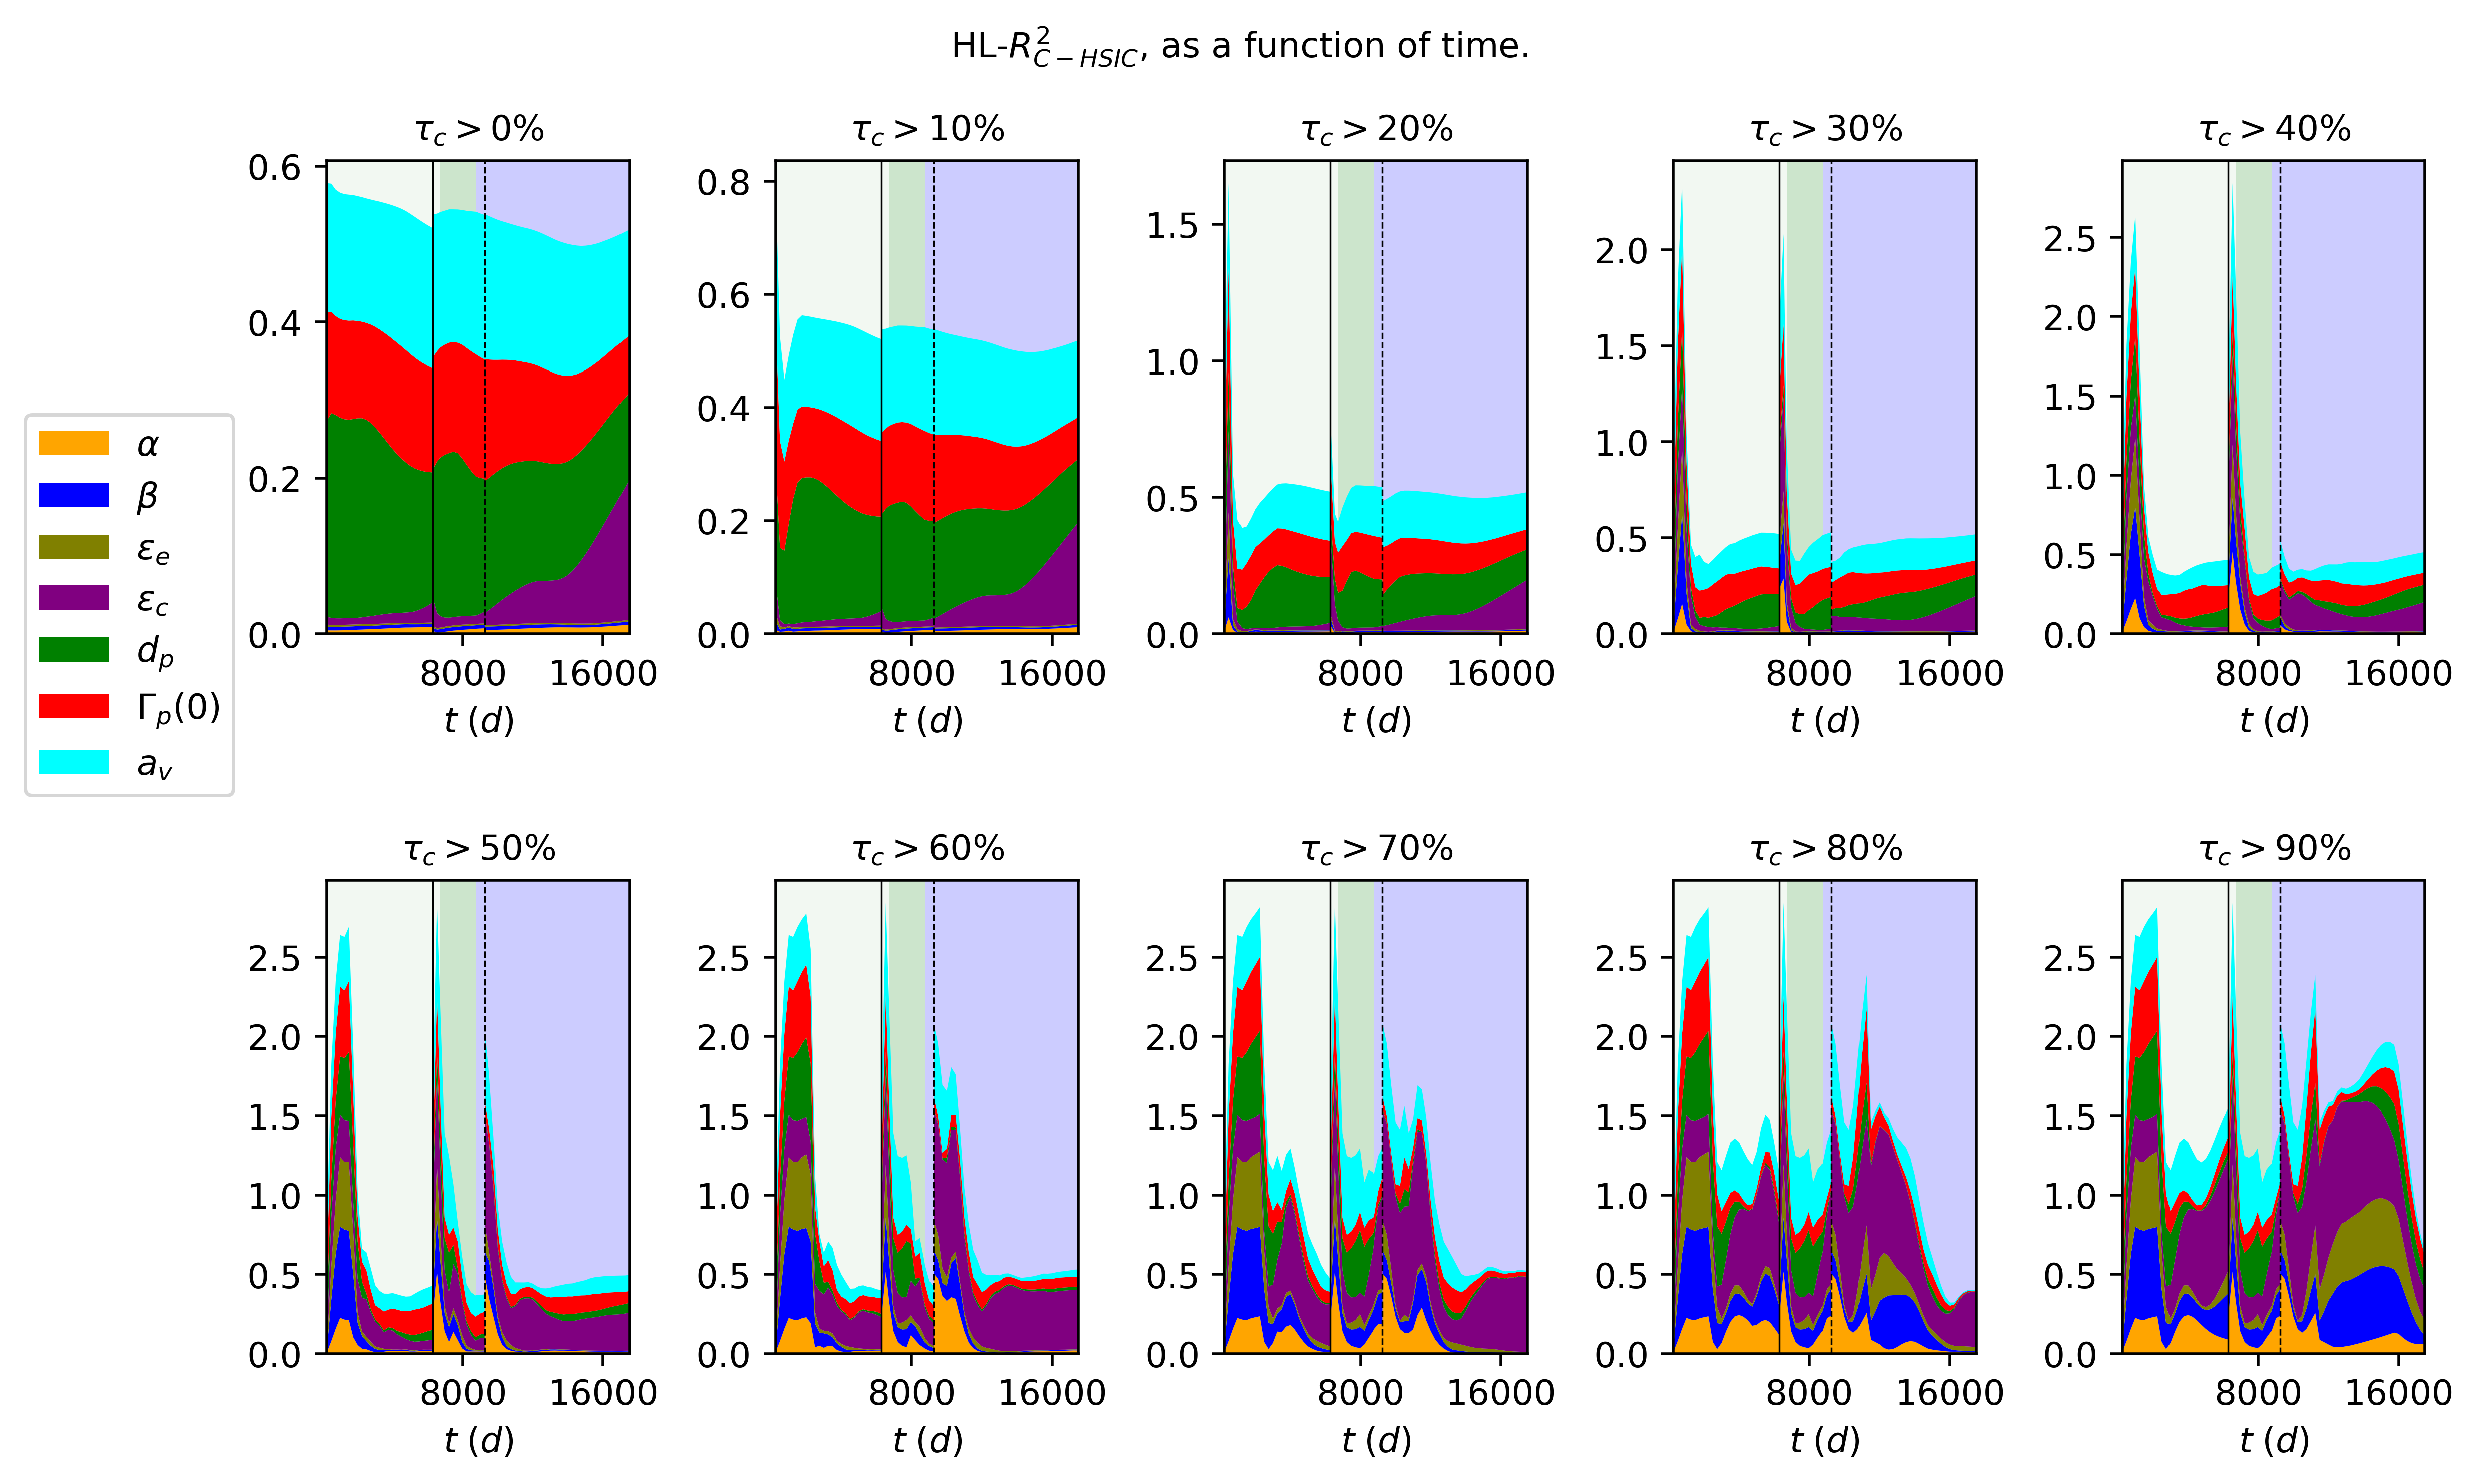

In [110]:
#Plot for different 

nrow, ncol = 2, 5
fig, axs = plt.subplots(nrow, ncol, figsize=(10,6), layout='tight')

colors = ['orange', 'blue', 'olive','purple', 'green', 'red','cyan']

cond = input_dic['SG']['chimie']['conditionnementSecondaire']
for k in range(len(cond)):
    if k == len(cond)-1:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, max(t)
    else:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, cond[k+1]['nbHeuresExploit']/24
    c = cond[k]
    typ = colors_ch[c['type']]
    col = typ[str(c['ph'])]
    for i, ax in enumerate(fig.axes):
            ax.axvspan(t_i, t_f, facecolor=col[0], alpha = col[1])
for i, ax in enumerate(fig.axes):
    ax.stackplot(t,hsic_cond_diff_time_HL[i].T, labels=labels, colors=colors)
    ax.set_xlim(250,17500)
    ax.set_xlabel(r'$t\;(d)$')
    ax.set_title(r'$\tau_c > {}\%$'.format(tau_levels[i]), fontsize=10)
    ax.xaxis.set_major_locator(plt.MaxNLocator(1))


nett = input_dic['SG']['chimie']['nettoyage']
for k in range(len(nett)):
    if nett[k]['type'] == 'curatif':
        for i, ax in enumerate(fig.axes):
            ax.axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)

    elif nett[k]['type'] == 'preventif':
        for i, ax in enumerate(fig.axes):
            ax.axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)

axs[0,0].legend(bbox_to_anchor=(-0.25,0.5))
fig.suptitle(r'HL-$R^2_{C-HSIC}$, as a function of time.', fontsize=10)

fig.savefig('../plots/HSIC/HL_conditional_HSIC.pdf', format='pdf')
fig.savefig('../plots/HSIC/HL_conditional_HSIC.png', format='png')

        

## HL - p-values

In [111]:
p_values_cond_diff_HL = np.asarray(p_values_cond_diff_HL)

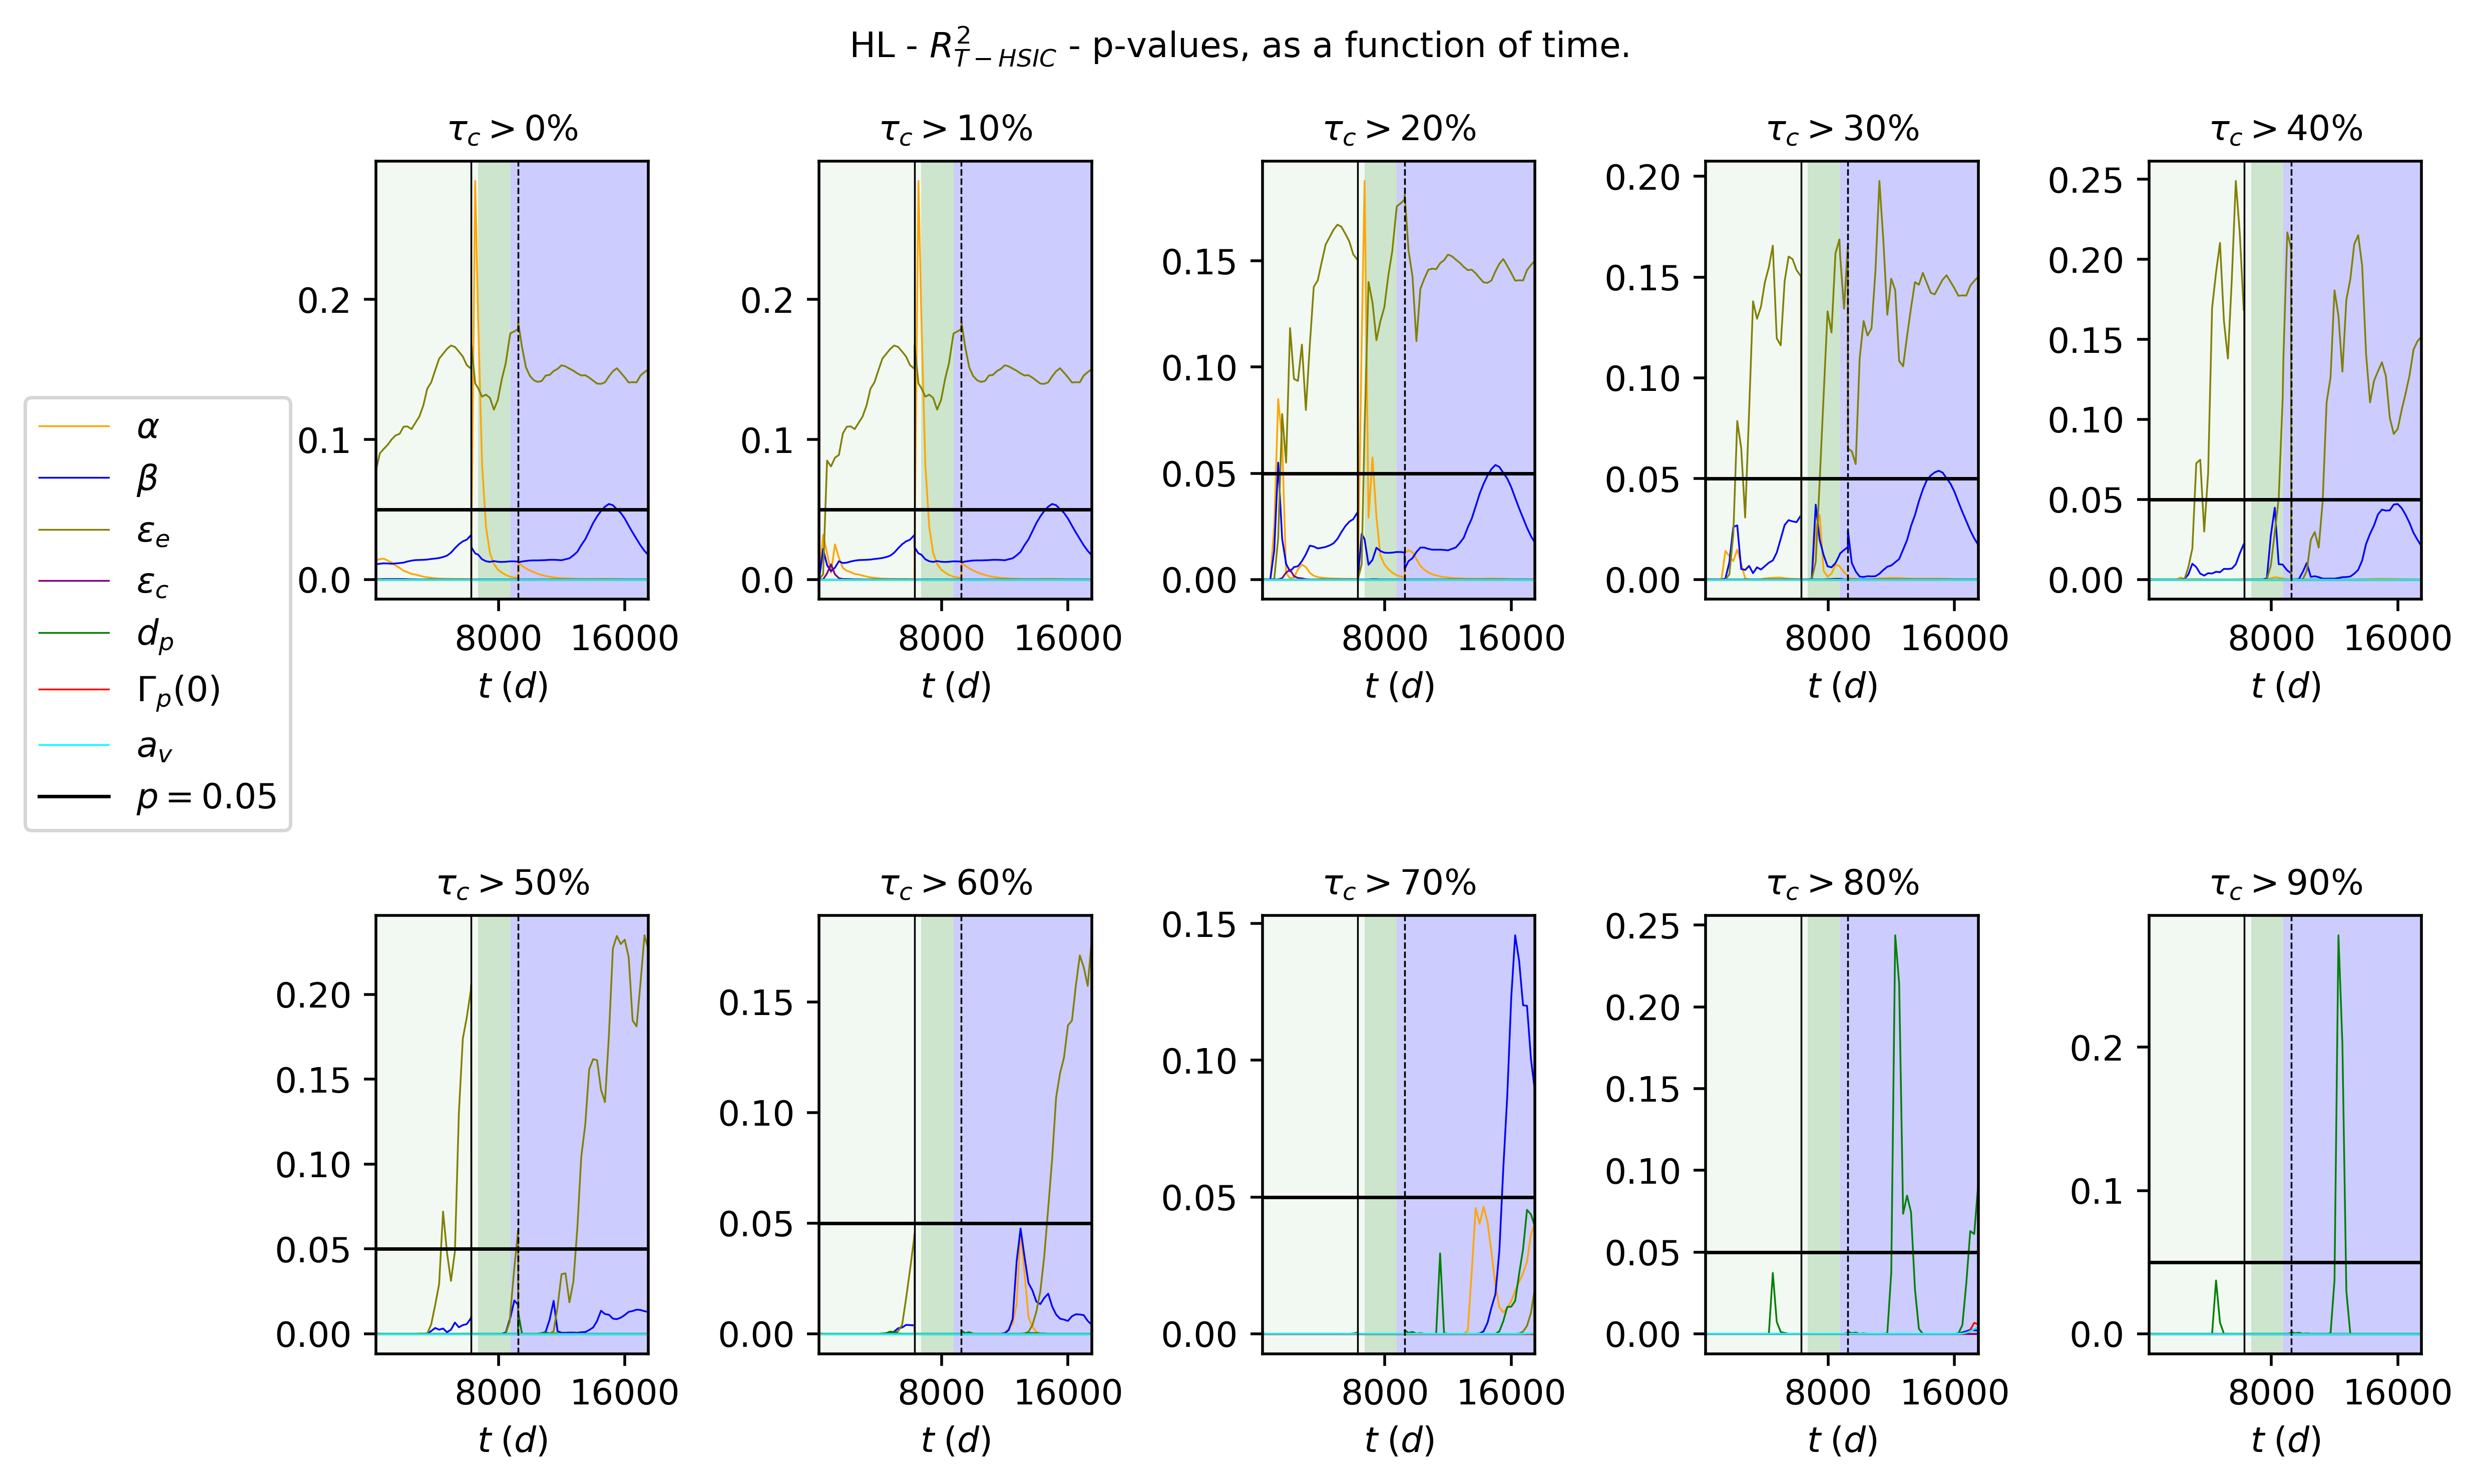

In [112]:
#Plot for different 
nrow, ncol = 2, 5
fig, axs = plt.subplots(nrow, ncol, figsize=(10,6), layout='tight')

colors = ['orange', 'blue', 'olive','purple', 'green', 'red','cyan']

cond = input_dic['SG']['chimie']['conditionnementSecondaire']
for k in range(len(cond)):
    if k == len(cond)-1:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, max(t)
    else:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, cond[k+1]['nbHeuresExploit']/24
    c = cond[k]
    typ = colors_ch[c['type']]
    col = typ[str(c['ph'])]
    for i, ax in enumerate(fig.axes):
            ax.axvspan(t_i, t_f, facecolor=col[0], alpha = col[1])
for i, ax in enumerate(fig.axes):
    for k in range(7):
        ax.plot(t,p_values_cond_diff_HL[i].T[k], label=labels[k], c=colors[k], linewidth=0.5)
    ax.set_xlim(250,17500)
    ax.set_xlabel(r'$t\;(d)$')
    ax.set_title(r'$\tau_c > {}\%$'.format(tau_levels[i]), fontsize=10)
    ax.xaxis.set_major_locator(plt.MaxNLocator(1))
    ax.axhline(y=0.05, linewidth=1.0, color='k', label=r'$p=0.05$')



nett = input_dic['SG']['chimie']['nettoyage']
for k in range(len(nett)):
    if nett[k]['type'] == 'curatif':
        for i, ax in enumerate(fig.axes):
            ax.axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)

    elif nett[k]['type'] == 'preventif':
        for i, ax in enumerate(fig.axes):
            ax.axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)

axs[0,0].legend(bbox_to_anchor=(-0.25,0.5))
fig.suptitle(r'HL - $R^2_{T-HSIC}$ - p-values, as a function of time.', fontsize=10)

fig.savefig('../plots/HSIC/HL_conditional_HSIC_pval.pdf', format='pdf')
fig.savefig('../plots/HSIC/HL_conditional_HSIC_pval.png', format='png')
        